# Data Downloading

In [ ]:
from IPython.display import clear_output

root_dir = "/content"
!cd $root_dir
clear_output()

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.8/766.8 KB 12.2 MB/s eta 0:00:00


In [ ]:
root_dir = "/content"
!cd $root_dir

# Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric, ConfusionMatrixMetric

%matplotlib inline

print_config()

MONAI version: 0.9.dev2211
Numpy version: 1.21.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 9c0d89cb7c774cba53242b9a3981fd02e75f3902
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.2.2
TorchVision version: 0.11.1+cu111
tqdm version: 4.63.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# AICrowd Libs

In [ ]:
class OutOfBudetException(Exception):
    """Out of labelling budget"""
    def __init__(self, available_budget):
        self.available_budget = available_budget
        self.message = "Already Exhausted Label Purchasing Budget of : {}".format(
            self.available_budget
        )
        super().__init__(self.message)

import torch
import numpy as np 

from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

def exact_match_ratio(y_true, y_pred):
    if type(y_pred) == torch.Tensor:
        y_pred = y_pred.numpy()
    
    return np.all(y_pred == y_true, axis=1).mean()


import os
import math
import pandas as pd

import torch
from torchvision import transforms

from torch.utils.data import Dataset

import tqdm

from skimage import io
import numpy as np
#from .exceptions import OutOfBudetException


class ZEWDPCBaseDataset(Dataset):
    """
    ZEW Data Purchasing Challenge Base Dataset Class
    """

    def __init__(
        self,
        images_dir,
        labels_path,
        drop_labels: bool = False,
        shuffle_seed=None,
        transform=None,
    ):
        """
        Initializes a ZEWDPCBaseDataset class.

        Args:
            images_dir      : Directory containing dataset images referenced in the annotation file
            labels_path     : Path to the CSV file containing labels for all the images in the dataset
            drop_labels     : Boolean value which determines if the labels should be dropped from the response
                              when accessing the dataset via `ZEWDPCBaseDataset.__getitem__(...)`.
            shuffle_seed    : Seed for reproducibility during the shuffle of dataset rows during initialization
            transform       : A transformation function to pre-process the images before they are served to the models.
        """
        self.images_dir = images_dir
        self.labels_path = labels_path

        self.drop_labels = drop_labels
        self.shuffle_seed = shuffle_seed  # Seed used to shuffle the rows of the dataset

        self.transform = transform

        self.labels_column_names = [
            "scratch_small",
            "scratch_large",
            "dent_small",
            "dent_large",
        ]
        self.validate_and_load_labels_file()

        self.dict_images = {}

    def validate_and_load_labels_file(self):
        """
        Internal function to validate and load the labels file.
        """
        self.labels_df = pd.read_csv(self.labels_path)
        # Shuffle all the rows across each instantiation
        self.labels_df = self.labels_df.sample(
            frac=1, random_state=self.shuffle_seed
        ).reset_index(drop=True)

        if self.drop_labels:
            # Drop Label Columns if they are present in the labels file
            label_columns = set(self.labels_df.columns).intersection(
                self.labels_column_names
            )
            self.labels_df = self.labels_df.drop(label_columns, axis=1)

    def __len__(self):
        return len(self.labels_df)

    def _get_row(self, idx: int):
        """
        Access a row from the dataframe representing the dataset

        Args:
            idx: index of the row in the dataframe

        Returns:
            pandas.core.series.Series object representing a row in the dataset
        """
        row = self.labels_df.iloc[idx]
        return row

    def _get_label(self, idx: int):
        """
        Get the labels for the data point at a particular index.

        Args:
            idx: index of the datapoint

        Returns:
            a list representing the labels for the data point at a particular index.
            Example [0, 1, 1, 0]
        """
        idx = self._validate_idx(idx)
        row = self._get_row(idx)
        # Gather the label based on the order of the keys in the labels_column_names
        label = [row[x] for x in self.labels_column_names]
        return label

    def _get_all_labels(self):
        """
        Returns all the labels for the whole dataset.
        Useful during the evaluation for comparison with the ground_truth.
        """
        return self.labels_df[self.labels_column_names].to_numpy()
    
    def _get_filename(self, idx):
        row = self._get_row(idx)
        filename = row.filename.replace(".png", "").replace(".jpg", "")
        return filename

    def __getitem__(self, idx: int):
        """
        Function to access an image, label pair at a parituclar index.

        Args:
            idx: index of the datapoint

        Returns:
            A dictionary object with the following keys :
                - `image`
                    Holds a representation of the image at the referenced index.
                    It can either be the raw image, as loaded by skimage.io.imread
                    or if a `transform` function is provided, then it the transformed
                    representation of the image.
                - `label`
                    Holds a representation of the labels at the referenced index.
                    The structure of the labels are the same as returned by the `self._get_label` function.

                    NOTE: if `drop_labels` is True, then the `label` key is excluded from the dictionary.
        """
        idx = self._validate_idx(idx)

        row = self._get_row(idx)

        # Collect Image
        if idx not in self.dict_images:
            filename = row["filename"]
            image_path = os.path.join(self.images_dir, filename)
            image = io.imread(image_path)
            self.dict_images[idx] = image
        else:
            image = self.dict_images[idx]

        # Prepare Response Sample
        sample = {}
        sample["idx"] = idx
        sample["image"] = image
        if not self.drop_labels:
            sample["label"] = self._get_label(idx)

        # Apply Transformations
        if self.transform:
            sample["image"] = self.transform(sample["image"])

        return sample

    def set_transform(self, transform):
        """
        Function to set a transformation function for the images in the dataset.

        Args:
            transform: A transformation function which takes as input a raw image
                as loaded by `skimage.io.imread` and returns a representation of the
                image, as required by the participants.
                `torchvision.transforms` (https://pytorch.org/vision/stable/transforms.html)
                are supported.
        """
        self.transform = transform

    ########################################################################
    ########################################################################
    # Utils
    ########################################################################
    ########################################################################

    def _validate_idx(self, idx):
        if torch.is_tensor(idx):
            # `pandas.DataFrame` does not accept tensors as indices
            # so if idx is a tensor, then we convert it into an scalar idx
            idx = idx.item()
        return idx

class ZEWDPCProtectedDataset(ZEWDPCBaseDataset):
    """
    A protected Dataset access object which wraps over an `ZEWDPCBaseDataset` object
    and manages a data purchase policy for the dataset.

    This shares the same interfaces as the ZEWDPCBaseDataset class, and the key differences are :
        * The labels are not included by default in the samples when you iterate over this dataset.
        * Allows participants to iteratively purchase the labels of certain datapoints, while respecting the available
            budget.
    """

    def __init__(
        self,
        images_dir,
        labels_path,
        budget=None,
        shuffle_seed=None,
        transform=None,
    ):
        super().__init__(
            images_dir=images_dir,
            labels_path=labels_path,
            drop_labels=False,
            shuffle_seed=shuffle_seed,
            transform=transform,
        )

        self.budget = math.inf if budget == None else budget
        # Manages a set of purchased labels
        self.purchases = set()

    def purchase_label(self, idx: int):
        """
        Request to purchase the label for a sample.

        Returns the label if :
            * if there is still budget available to purchase more
        else:
            throws an exception

        NOTE: If you do not use this function to access the labels,
        and instead try to access it locally using self.__base_dataset,
        your code will not be functional in the evaluation setup.
        """
        if self.check_available_budget() > 0 or (idx in self.purchases):
            self.purchases.add(idx)
            label = self._get_label(idx)
            return label
        else:
            raise OutOfBudetException(self.budget)

    def check_available_budget(self):
        """
        Returns the available label-access budget
        """
        return self.budget - len(self.purchases)


In [ ]:
import tempfile
import numpy as np
from tqdm.auto import tqdm

#from evaluator.dataset import ZEWDPCBaseDataset, ZEWDPCProtectedDataset
#from run import ZEWDPCBaseRun

####################################################################################
####################################################################################
##
## Dataset Initialization
## We have initialised it with debug images for faster onboarding, you can change
## the location to respective dataset splits after downloading them.
####################################################################################
DATASET_SHUFFLE_SEED = 1022022

# Instantiate Training Dataset
training_dataset = ZEWDPCBaseDataset(
    images_dir=f"{root_dir}/input/origin/training/training/images",
    labels_path=f"{root_dir}/input/origin/training/training/labels.csv",
    shuffle_seed=DATASET_SHUFFLE_SEED,
)
# Instantiate Unlabelled Dataset
unlabelled_dataset = ZEWDPCProtectedDataset(
    images_dir=f"{root_dir}/input/origin/unlabelled/unlabelled/images",
    labels_path=f"{root_dir}/input/origin/unlabelled/unlabelled/labels.csv",
    budget=3000,  # Configurable Parameter
    shuffle_seed=DATASET_SHUFFLE_SEED,
)
# Instantiate Validation Dataset
val_dataset = ZEWDPCBaseDataset(
    images_dir=f"{root_dir}/input/origin/validation/validation/images",
    labels_path=f"{root_dir}/input/origin/validation/validation/labels.csv",
    drop_labels=True,
    shuffle_seed=DATASET_SHUFFLE_SEED,
)
# A second instantiation of the validation test with the labels present
#       - helpful later, when computing the scores.
val_dataset_gt = ZEWDPCBaseDataset(
    images_dir=f"{root_dir}/input/origin/validation/validation/images",
    labels_path=f"{root_dir}/input/origin/validation/validation/labels.csv",
    drop_labels=False,
    shuffle_seed=DATASET_SHUFFLE_SEED,
)

# Location to save your checkpoint
checkpoint_path = tempfile.NamedTemporaryFile(delete=False).name

# load all images in memory
if False:
    for ds in [training_dataset, unlabelled_dataset, val_dataset, val_dataset_gt]:
        for sample in tqdm(ds):
            pass

In [ ]:
print(unlabelled_dataset.images_dir)
unlabelled_dataset.labels_df

/content/input/origin/unlabelled/unlabelled/images


filename  scratch_small  scratch_large  dent_small  dent_large
0     ziqPj61SJY.png              0              1           0           0
1     Pfd2tYRboY.png              1              1           0           1
2     qp2GMwY7ys.png              0              0           1           0
3     f2qbW6EUhA.png              0              0           0           0
4     Y0bGXhjIto.png              0              1           0           0
...              ...            ...            ...         ...         ...
9995  legN5WLS4r.png              0              0           1           0
9996  JprLQwedOp.png              1              0           1           0
9997  LQHk68jtA8.png              1              0           0           0
9998  7cmAg5e6QA.png              0              1           0           0
9999  LIV3Q7fUZe.png              1              1           0           0

[10000 rows x 5 columns]

In [ ]:
#        filename = row["filename"]
#        image_path = os.path.join(self.images_dir, filename)
#        image = io.imread(image_path)
print(unlabelled_dataset.images_dir)
unlabelled_dataset.labels_df.tail()

/content/input/origin/unlabelled/unlabelled/images


filename  scratch_small  scratch_large  dent_small  dent_large
9995  legN5WLS4r.png              0              0           1           0
9996  JprLQwedOp.png              1              0           1           0
9997  LQHk68jtA8.png              1              0           0           0
9998  7cmAg5e6QA.png              0              1           0           0
9999  LIV3Q7fUZe.png              1              1           0           0

# Model

In [ ]:
#--------------------------------------------------------------------------------
# My classes: BEGIN
#--------------------------------------------------------------------------------

import torch
from torch import nn
from torchvision import models
from torch.optim import Adam, SGD, lr_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import math
import datetime
from pathlib import Path

from tqdm import tqdm
from tqdm import trange

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader

from monai.networks.nets import AutoEncoder
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    Rotate90,
    RandRotate90,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    EnsureChannelFirst,
    Transform,
    Transpose,
    RandAdjustContrast
)

from monai.utils import set_determinism
print_config()

def print_time(x=""):
    now_str = "{date:%Y-%m-%d %H:%M:%S %f}".format(date=datetime.datetime.now())
    print(now_str, ": " + str(x) if len(str(x)) > 0 else "")

class MyModel():
    # model_arch="efficientnet-b0" vs Densenet169
    def __init__(self, root_dir="/public"):
        self.root_dir = root_dir
        if root_dir != "/public":
            Path(root_dir).mkdir(parents=True, exist_ok=True) 

        # Custom code
        self.train_transforms = Compose( [
                LoadImage(image_only=True),
                Transpose((2, 0, 1)),#SwapChannel(),
                ScaleIntensity(),
                RandAdjustContrast(),
                RandRotate90(),
                RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
                RandFlip(spatial_axis=0, prob=0.5),
                RandFlip(spatial_axis=1, prob=0.5),
                RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
                EnsureType(),
        ])

        self.val_transforms = Compose([
                LoadImage(image_only=True),
                Transpose((2, 0, 1)),
                ScaleIntensity(), EnsureType()
        ])

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        set_determinism(seed=0)

        if torch.cuda.is_available():
            batch_size=128
            num_workers=4
        else:
            batch_size=2
            num_workers=2       
        self.batch_size = batch_size
        self.num_workers = num_workers

        pwd = os.getcwd()

    def train_filenames(self, train_images, 
                            val_frac=0.1, max_epochs=10, 
                            phase="production", verbose=True):
      
        print_time("Start training")
        device = self.device

        print("-"*40)

        length = len(train_images)
        indices = np.arange(length)
        np.random.shuffle(indices)

        val_split = int(val_frac * length)
        val_indices = indices[:val_split]
        train_indices = indices[val_split:]

        train_x = [train_images[i] for i in train_indices]
        val_x = [train_images[i] for i in val_indices]

        if verbose:
            print("Total size", len(train_images))
            print(len(train_x), len(val_x))

        train_ds = CacheDataset(train_x, self.train_transforms, num_workers=self.num_workers)
        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=self.num_workers)

        val_ds = CacheDataset(val_x, self.val_transforms, num_workers=self.num_workers)
        val_loader = DataLoader(val_ds, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)

        def train(max_epochs=10, learning_rate=1e-3):
            model = AutoEncoder(
                spatial_dims=2,
                in_channels=3,
                out_channels=3,
                channels=(4, 8, 16, 32),
                strides=(2, 2, 2, 2),
            ).to(device)

            # Create loss fn and optimiser
            loss_function = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), learning_rate)

            epoch_loss_values = []
            val_losses = []

            t = trange(
                max_epochs,
                desc=f"-- epoch 0, avg loss: inf", leave=True)
            for epoch in t:
                model.train()
                epoch_loss = 0
                step = 0
                for batch_data in train_loader:
                    step += 1
                    inputs = batch_data.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_function(outputs, batch_data.to(device))
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                epoch_loss_values.append(epoch_loss)
                #t.set_description(
                #    f"-- epoch {epoch + 1}"
                #    + f", average loss: {epoch_loss:.4f}")
                
                # Test
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_data in val_loader:
                        inputs = batch_data.to(device)
                        outputs = model(inputs)
                        # sum up batch loss
                        val_loss += loss_function(outputs, batch_data.to(device)).item()
                val_losses.append(val_loss * len(train_loader.dataset) / len(val_loader.dataset))

                t.set_description(
                    f"-- epoch {epoch + 1}, train loss: "
                    f"{epoch_loss_values[-1]:.4f}, test loss: {val_losses[-1]:.4f}")
                
            return model, epoch_loss_values, val_losses
        
        model, epoch_loss_values, val_losses = train(max_epochs=max_epochs)

        model_filename = f"{self.root_dir}/{phase}_autoencoder.pth"
        torch.save(model.state_dict(), model_filename)

        try:
            del model
            del val_loader
            del val_ds
            del train_loader
            del train_ds
            torch.cuda.empty_cache()
        except:
            pass

        print_time("Stop training")
        print("-"*40)
        return model_filename, epoch_loss_values, val_losses

    def score_filenames(self, test_images, phase="production", verbose=True):
        print_time("Start scoring")
        print("-"*40)
        device = self.device

        test_ds = CacheDataset(test_images, self.val_transforms, num_workers=self.num_workers)
        test_loader = DataLoader(test_ds, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)
                    
        model = AutoEncoder(
                spatial_dims=2,
                in_channels=3,
                out_channels=3,
                channels=(4, 8, 16, 32),
                strides=(2, 2, 2, 2),
            ).to(device)

        model_filename = f"{self.root_dir}/{phase}_autoencoder.pth"
        model.load_state_dict(torch.load(model_filename, map_location=torch.device(self.device)))

        model.to(self.device)
        model.eval()

        errors = []
        with torch.no_grad():
            for batch_data in test_loader:
                inputs = batch_data.to(device)
                outputs = model(inputs)

                outputs = outputs.detach().cpu().numpy()
                inputs = inputs.detach().cpu().numpy()

                diff = (outputs-inputs)
                diff = diff*diff
                
                errors += [math.sqrt(d.sum()) for d in diff]

        print_time("Stop scoring")
        print("-"*40)
        return errors
#--------------------------------------------------------------------------------
# My classes: END
#--------------------------------------------------------------------------------

MONAI version: 0.9.dev2211
Numpy version: 1.21.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 9c0d89cb7c774cba53242b9a3981fd02e75f3902
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.2.2
TorchVision version: 0.11.1+cu111
tqdm version: 4.63.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
def my_purchase_phase(
        root_dir,
        unlabelled_dataset: ZEWDPCProtectedDataset,
        training_dataset: ZEWDPCBaseDataset,
        purchase_budget=1000,
        compute_budget=15*60,
        register_progress=lambda x: False,
    ):

    print_time("===== TRAINING =====")
    register_progress(0.01) 

    model = MyModel(root_dir=root_dir)

    train_images = list(training_dataset.labels_df["filename"])
    train_images = [f"{training_dataset.images_dir}/{f}" for f in train_images]
    print(len(train_images))
    print(train_images[:3])

    register_progress(0.02) 
    # 3 minutes
    model_filename, epoch_loss_values, val_losses = model.train_filenames(train_images, 
                                val_frac=0.1, max_epochs=10, 
                                phase="production", verbose=True)
    
    register_progress(0.1) 

    PLOT_OPTION = False
    if PLOT_OPTION:
        plt.figure("train", (12, 6))
        plt.subplot(1, 1, 1)
        plt.title("Epoch Train Loss")
        x = [i + 1 for i in range(len(epoch_loss_values))]
        y = epoch_loss_values
        plt.xlabel("epoch")
        plt.plot(x, epoch_loss_values)
        plt.plot(x, val_losses)

        plt.show()

    print_time("===== SCORING =====")
    print_time()
    #model = MyModel(root_dir=root_dir)

    register_progress(0.11) 
    unlabelled_images = list(unlabelled_dataset.labels_df["filename"])
    unlabelled_images = [f"{unlabelled_dataset.images_dir}/{f}" for f in unlabelled_images]
    print(len(unlabelled_images))
    print(unlabelled_images[:3])
    register_progress(0.12) 

    # Training took 3 minutes for 5K, Scoring took 40 seconds for 10K:
    errors = model.score_filenames(unlabelled_images, phase="production", verbose=True)
    register_progress(0.2) 

    print_time("===== BUYING =====")
    register_progress(0.21) 

    nb_total = len(errors)
    df_errors = pd.Series(errors).reset_index()
    df_errors.columns = ["id", "error"]
    df_errors.sort_values("error", ascending=False, inplace=True)
    df_errors.reset_index(drop=True, inplace=True)
    idx_to_buy = list(df_errors.head(purchase_budget)["id"])
    print(len(idx_to_buy), idx_to_buy[:3])
    register_progress(0.22) 

    label_to_buy = [unlabelled_dataset.purchase_label(idx) for idx in idx_to_buy]
    register_progress(0.3) 
    print_time("===== DONE =====")

root_dir = "colab"
my_purchase_phase(
        root_dir,
        unlabelled_dataset,
        training_dataset,
        purchase_budget=1000,
        compute_budget=15*60,
        register_progress=lambda x: print_time(f"+-*/ at {x}"),
    )

2022-03-14 10:59:24 230270 : ===== TRAINING =====
2022-03-14 10:59:24 230443 : +-*/ at 0.01
5000
['/content/input/origin/training/training/images/ELaNlPdO6b.png', '/content/input/origin/training/training/images/HnoUw8OC15.png', '/content/input/origin/training/training/images/n6kbK7pBxH.png']
2022-03-14 10:59:24 236134 : +-*/ at 0.02
2022-03-14 10:59:24 236189 : Start training
----------------------------------------
Total size 5000
4500 500


Loading dataset: 100%|██████████| 500/500 [00:01<00:00, 402.38it/s]
-- epoch 10, train loss: 0.5459, test loss: 0.5051: 100%|██████████| 10/10 [01:52<00:00, 11.25s/it]


2022-03-14 11:01:30 746987 : Stop training
----------------------------------------
2022-03-14 11:01:30 748910 : +-*/ at 0.1
2022-03-14 11:01:30 749024 : ===== SCORING =====
2022-03-14 11:01:30 749086 
2022-03-14 11:01:30 749155 : +-*/ at 0.11
10000
['/content/input/origin/unlabelled/unlabelled/images/ziqPj61SJY.png', '/content/input/origin/unlabelled/unlabelled/images/Pfd2tYRboY.png', '/content/input/origin/unlabelled/unlabelled/images/qp2GMwY7ys.png']
2022-03-14 11:01:30 753801 : +-*/ at 0.12
2022-03-14 11:01:30 753904 : Start scoring
----------------------------------------


Loading dataset: 100%|██████████| 10000/10000 [00:23<00:00, 423.47it/s]


2022-03-14 11:02:09 535881 : Stop scoring
----------------------------------------
2022-03-14 11:02:12 588248 : +-*/ at 0.2
2022-03-14 11:02:12 588397 : ===== BUYING =====
2022-03-14 11:02:12 588487 : +-*/ at 0.21
1000 [2823, 3033, 6328]
2022-03-14 11:02:12 598027 : +-*/ at 0.22
2022-03-14 11:02:12 713388 : +-*/ at 0.3
2022-03-14 11:02:12 713491 : ===== DONE =====


In [ ]:
purchase_budget=1000
nb_total = len(errors)
df_errors = pd.Series(errors).reset_index()
df_errors.columns = ["id", "error"]
df_errors.sort_values("error", ascending=False, inplace=True)
df_errors.reset_index(drop=True, inplace=True)
idx_to_buy = list(df_errors.head(purchase_budget)["id"])
print(len(idx_to_buy), idx_to_buy[:3])
#qcut = df_errors["error"].quantile(1-purchase_budget/nb_total)
df_errors

1000 [2823, 3033, 6328]


id       error
0     2823  123.387518
1     3033  113.820754
2     6328  109.724606
3     6902  109.661549
4      707  109.556225
...    ...         ...
9995   988   22.848594
9996   567   22.781791
9997  2075   22.692236
9998  7825   22.623099
9999   805   22.493609

[10000 rows x 2 columns]

In [ ]:
df_errors

id      error
0        0  61.411371
1        1  30.303680
2        2  36.238352
3        3  44.920652
4        4  44.363276
...    ...        ...
9995  9995  52.494182
9996  9996  43.176082
9997  9997  74.250753
9998  9998  56.064551
9999  9999  44.872367

[10000 rows x 2 columns]

# Details

In [ ]:
root_dir = "colab"

print_time()
model = MyModel(root_dir=root_dir)

train_images = list(training_dataset.labels_df["filename"])
train_images = [f"{training_dataset.images_dir}/{f}" for f in train_images]
print(len(train_images))
print(train_images[:3])

# 3 minutes
model_filename, epoch_loss_values, val_losses = model.train_filenames(train_images, 
                            val_frac=0.1, max_epochs=10, 
                            phase="production", verbose=True)

2022-03-14 10:37:40 872855 
5000
['/content/input/origin/training/training/images/ELaNlPdO6b.png', '/content/input/origin/training/training/images/HnoUw8OC15.png', '/content/input/origin/training/training/images/n6kbK7pBxH.png']
2022-03-14 10:37:40 946740 : Start training
----------------------------------------
Total size 5000
4500 500


Loading dataset: 100%|██████████| 500/500 [00:01<00:00, 460.96it/s]
-- epoch 10, train loss: 0.5459, test loss: 0.5051: 100%|██████████| 10/10 [01:30<00:00,  9.08s/it]


2022-03-14 10:39:34 093715 : Stop training
----------------------------------------


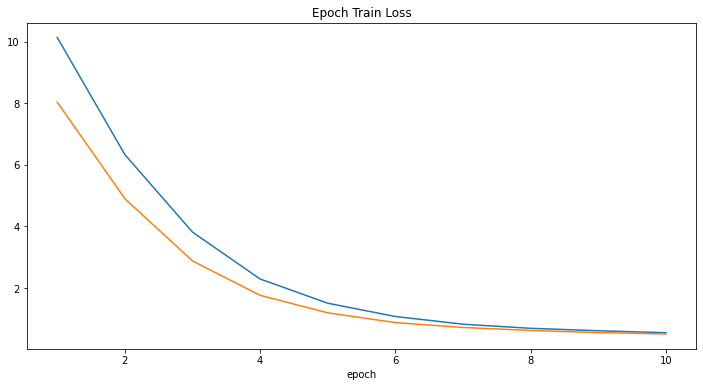

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 1, 1)
plt.title("Epoch Train Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, epoch_loss_values)
plt.plot(x, val_losses)

plt.show()

In [ ]:
root_dir = "colab"

print_time()
model = MyModel(root_dir=root_dir)

unlabelled_images = list(unlabelled_dataset.labels_df["filename"])
unlabelled_images = [f"{unlabelled_dataset.images_dir}/{f}" for f in unlabelled_images]
print(len(unlabelled_images))
print(unlabelled_images[:3])

# Training took 3 minutes for 5K, Scoring took 40 seconds for 10K:
errors = model.score_filenames(unlabelled_images, phase="production", verbose=True)

2022-03-14 10:39:34 251630 
10000
['/content/input/origin/unlabelled/unlabelled/images/ziqPj61SJY.png', '/content/input/origin/unlabelled/unlabelled/images/Pfd2tYRboY.png', '/content/input/origin/unlabelled/unlabelled/images/qp2GMwY7ys.png']
2022-03-14 10:39:34 260508 : Start scoring
----------------------------------------


Loading dataset: 100%|██████████| 10000/10000 [00:21<00:00, 462.35it/s]


2022-03-14 10:40:10 558366 : Stop scoring
----------------------------------------


10000


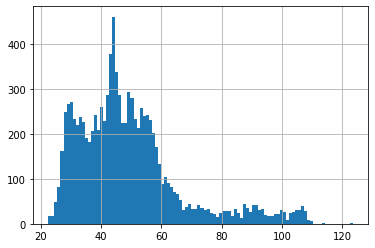

In [ ]:
print(len(errors))
s = pd.Series(errors)
s.hist(bins=100)

# Full run.py code

In [1]:
#!/usr/bin/env python

import os
import numpy as np
from tqdm.auto import tqdm

from evaluator.dataset import ZEWDPCBaseDataset, ZEWDPCProtectedDataset

#--------------------------------------------------------------------------------
# My classes: BEGIN
#--------------------------------------------------------------------------------

import torch
from torch import nn
from torchvision import models
from torch.optim import Adam, SGD, lr_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import math
import datetime
from pathlib import Path

from tqdm import tqdm
from tqdm import trange

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader

from monai.networks.nets import AutoEncoder
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    Rotate90,
    RandRotate90,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    EnsureChannelFirst,
    Transform,
    Transpose,
    RandAdjustContrast
)

from monai.utils import set_determinism
print_config()

def print_time(x=""):
    now_str = "{date:%Y-%m-%d %H:%M:%S %f}".format(date=datetime.datetime.now())
    print(now_str, ": " + str(x) if len(str(x)) > 0 else "")

class MyModel():
    # model_arch="efficientnet-b0" vs Densenet169
    def __init__(self, root_dir="/public"):
        self.root_dir = root_dir
        if root_dir != "/public":
            Path(root_dir).mkdir(parents=True, exist_ok=True) 

        # Custom code
        self.train_transforms = Compose( [
                LoadImage(image_only=True),
                Transpose((2, 0, 1)),#SwapChannel(),
                ScaleIntensity(),
                RandAdjustContrast(),
                RandRotate90(),
                RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
                RandFlip(spatial_axis=0, prob=0.5),
                RandFlip(spatial_axis=1, prob=0.5),
                RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
                EnsureType(),
        ])

        self.val_transforms = Compose([
                LoadImage(image_only=True),
                Transpose((2, 0, 1)),
                ScaleIntensity(), EnsureType()
        ])

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        set_determinism(seed=0)

        if torch.cuda.is_available():
            batch_size=128
            num_workers=4
        else:
            batch_size=2
            num_workers=2       
        self.batch_size = batch_size
        self.num_workers = num_workers

        pwd = os.getcwd()

    def train_filenames(self, train_images, 
                            val_frac=0.1, max_epochs=10, 
                            phase="production", verbose=True):
      
        print_time("Start training")
        device = self.device

        print("-"*40)

        length = len(train_images)
        indices = np.arange(length)
        np.random.shuffle(indices)

        val_split = int(val_frac * length)
        val_indices = indices[:val_split]
        train_indices = indices[val_split:]

        train_x = [train_images[i] for i in train_indices]
        val_x = [train_images[i] for i in val_indices]

        if verbose:
            print("Total size", len(train_images))
            print(len(train_x), len(val_x))

        train_ds = CacheDataset(train_x, self.train_transforms, num_workers=self.num_workers)
        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=self.num_workers)

        val_ds = CacheDataset(val_x, self.val_transforms, num_workers=self.num_workers)
        val_loader = DataLoader(val_ds, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)

        def train(max_epochs=10, learning_rate=1e-3):
            model = AutoEncoder(
                spatial_dims=2,
                in_channels=3,
                out_channels=3,
                channels=(4, 8, 16, 32),
                strides=(2, 2, 2, 2),
            ).to(device)

            # Create loss fn and optimiser
            loss_function = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), learning_rate)

            epoch_loss_values = []
            val_losses = []

            t = trange(
                max_epochs,
                desc=f"-- epoch 0, avg loss: inf", leave=True)
            for epoch in t:
                model.train()
                epoch_loss = 0
                step = 0
                for batch_data in train_loader:
                    step += 1
                    inputs = batch_data.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_function(outputs, batch_data.to(device))
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                epoch_loss_values.append(epoch_loss)
                #t.set_description(
                #    f"-- epoch {epoch + 1}"
                #    + f", average loss: {epoch_loss:.4f}")
                
                # Test
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_data in val_loader:
                        inputs = batch_data.to(device)
                        outputs = model(inputs)
                        # sum up batch loss
                        val_loss += loss_function(outputs, batch_data.to(device)).item()
                val_losses.append(val_loss * len(train_loader.dataset) / len(val_loader.dataset))

                t.set_description(
                    f"-- epoch {epoch + 1}, train loss: "
                    f"{epoch_loss_values[-1]:.4f}, test loss: {val_losses[-1]:.4f}")
                
            return model, epoch_loss_values, val_losses
        
        model, epoch_loss_values, val_losses = train(max_epochs=max_epochs)

        model_filename = f"{self.root_dir}/{phase}_autoencoder.pth"
        torch.save(model.state_dict(), model_filename)

        try:
            del model
            del val_loader
            del val_ds
            del train_loader
            del train_ds
            torch.cuda.empty_cache()
        except:
            pass

        print_time("Stop training")
        print("-"*40)
        return model_filename, epoch_loss_values, val_losses

    def score_filenames(self, test_images, 
                        phase="production", verbose=True):
        print_time("Start scoring")
        print("-"*40)
        device = self.device

        test_ds = CacheDataset(test_images, self.val_transforms, num_workers=self.num_workers)
        test_loader = DataLoader(test_ds, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)
                    
        model = AutoEncoder(
                spatial_dims=2,
                in_channels=3,
                out_channels=3,
                channels=(4, 8, 16, 32),
                strides=(2, 2, 2, 2),
            ).to(device)

        model_filename = f"{self.root_dir}/{phase}_autoencoder.pth"
        model.load_state_dict(torch.load(model_filename, map_location=torch.device(self.device)))

        model.to(self.device)
        model.eval()

        errors = []
        with torch.no_grad():
            for batch_data in test_loader:
                inputs = batch_data.to(device)
                outputs = model(inputs)

                outputs = outputs.detach().cpu().numpy()
                inputs = inputs.detach().cpu().numpy()

                diff = (outputs-inputs)
                diff = diff*diff
                
                errors += [math.sqrt(d.sum()) for d in diff]

        print_time("Stop scoring")
        print("-"*40)
        return errors
#--------------------------------------------------------------------------------
# My classes: END
#--------------------------------------------------------------------------------

#--------------------------------------------------------------------------------
# My functions: BEGIN
#--------------------------------------------------------------------------------
def my_purchase_phase(
        root_dir,
        unlabelled_dataset: ZEWDPCProtectedDataset,
        training_dataset: ZEWDPCBaseDataset,
        purchase_budget=1000,
        compute_budget=15*60,
        register_progress=lambda x: False,
    ):

    print_time("===== TRAINING =====")
    register_progress(0.01) 

    model = MyModel(root_dir=root_dir)

    train_images = list(training_dataset.labels_df["filename"])
    train_images = [f"{training_dataset.images_dir}/{f}" for f in train_images]


    print(len(train_images))
    print(train_images[:3])

    register_progress(0.02) 
    # 3 minutes
    model_filename, epoch_loss_values, val_losses = model.train_filenames(train_images, 
                                val_frac=0.1, max_epochs=8, 
                                phase="production", verbose=True)
    
    register_progress(0.1) 

    PLOT_OPTION = False
    if PLOT_OPTION:
        plt.figure("train", (12, 6))
        plt.subplot(1, 1, 1)
        plt.title("Epoch Train Loss")
        x = [i + 1 for i in range(len(epoch_loss_values))]
        y = epoch_loss_values
        plt.xlabel("epoch")
        plt.plot(x, epoch_loss_values)
        plt.plot(x, val_losses)

        plt.show()

    print_time("===== SCORING =====")
    print_time()
    #model = MyModel(root_dir=root_dir)

    register_progress(0.11) 
    unlabelled_images = list(unlabelled_dataset.labels_df["filename"])
    unlabelled_images = [f"{unlabelled_dataset.images_dir}/{f}" for f in unlabelled_images]
    print(len(unlabelled_images))
    print(unlabelled_images[:3])
    register_progress(0.12) 

    # Training took 3 minutes for 5K, Scoring took 40 seconds for 10K:
    errors = model.score_filenames(unlabelled_images, phase="production", verbose=True)
    register_progress(0.2) 

    print_time("===== BUYING =====")
    register_progress(0.21) 

    nb_total = len(errors)
    df_errors = pd.Series(errors).reset_index()
    df_errors.columns = ["id", "error"]

    ascending=True

    df_errors.sort_values("error", ascending=ascending, inplace=True)
    df_errors.reset_index(drop=True, inplace=True)
    
    EVERY_STEP_SELECT = True
    if not EVERY_STEP_SELECT:
        idx_to_buy = list(df_errors.head(purchase_budget)["id"])
    else:
        nb_rows = nb_total # df_errors.shape[0]
        r = nb_rows // purchase_budget
        if r <= 0:
            r = 1
        idx_to_buy = list(df_errors.iloc[::r, :].reset_index(drop=True).head(purchase_budget)["id"])


    print(len(idx_to_buy), idx_to_buy[:3])
    register_progress(0.22) 

    label_to_buy = [unlabelled_dataset.purchase_label(idx) for idx in idx_to_buy]
    register_progress(0.3) 
    print_time("===== DONE =====")
#--------------------------------------------------------------------------------
# My functions: END
#--------------------------------------------------------------------------------

class ZEWDPCBaseRun:
    """
    Template Submission Class for the ZEW Data Purchasing Challenge 2022.

    The submission template follows the following hooks :
        - pre_training_phase
        - purchase_phase
        - prediction_phase
        - save_checkpoint
        - load_checkpoint

        Please refer to the inline documentation for further details.
        You are allowed to add any other member functions, however you
        are not allowed to change the names of these hooks, otherwise your
        submissions will not be evaluated by the automated evaluators.
    """

    def __init__(self):
        self.evaluation_state = {}

    def pre_training_phase(
        self,
        training_dataset: ZEWDPCBaseDataset,
        compute_budget=10**10,
        register_progress=lambda x: False,
    ):
        """
        # Pre-training Phase
        -------------------------
        Pre-train your model on the available training dataset here.
        Hook for the Pre-Training Phase of the Competition, where you
        have access to a training_dataset, which is an instance of the
        `ZEWDPCBaseDataset` class (see `evaluator/dataset.py` for more details).

        You are allowed to pre-train on this data, while you prepare
        for the Purchase_Phase of the competition.

        If you train some models, you can instantiate them as `self.model`,
        as long as you implement self-contained checkpointing in the
        `self.save_checkpoint` and `self.load_checkpoint` hooks, as the
        hooks for the different phases of the competition, can be called
        in different executions of the BaseRun.

        The `compute_budget` argument holds a floating point number representing
        the time available (in seconds) for **BOTH** the pre_training_phase and
        the `purchase_phase`.
        Exceeding the time will lead to a TimeOut error.

        PARTICIPANT_TODO: Add your code here
        """
        print("\n================> Pre-Training Phase\n")

        iteration = 0
        for sample in tqdm(training_dataset):
            iteration += 1

            progress = iteration / len(training_dataset)
            register_progress(progress)  # [Optional, but recommended] Mark Progress
            """
            You also have access to a `register_progress` function, to which you can
            pass a value between [0,1] to relay onto the leaderboard your self reported
            progress on the training phase to be displayed on the submission dashboard
            during the evaluation. If a value out of these bounds is provided, it will
            be clipped to this range.
            """

        print("Execution Complete of Training Phase.")

    def purchase_phase(
        self,
        unlabelled_dataset: ZEWDPCProtectedDataset,
        training_dataset: ZEWDPCBaseDataset,
        purchase_budget=1000,
        compute_budget=10**10,
        register_progress=lambda x: False,
    ):
        """
        # Purchase Phase
        -------------------------
        In this phase of the competition, you have access to
        the unlabelled_dataset (an instance of `ZEWDPCProtectedDataset`)
        and the training_dataset (an instance of `ZEWDPCBaseDataset`)
        {see datasets.py for more details}, a purchase budget, and a compute budget.

        You can iterate over both the datasets and access the images without restrictions.
        However, you can probe the labels of the unlabelled_dataset only until you
        run out of the label purchasing budget.

        The `compute_budget` argument holds a floating point number representing
        the time available (in seconds) for **BOTH** the pre_training_phase and
        the `purchase_phase`.
        Exceeding the time will lead to a TimeOut error.

        PARTICIPANT_TODO: Add your code here
        """
        print("\n================> Purchase Phase | Budget = {}\n".format(purchase_budget))

        register_progress(0.0)  # Register Progress

        RANDOM_PURCHASE = False
        if RANDOM_PURCHASE:
            purchased_labels = {}
            for sample in tqdm(unlabelled_dataset):
                idx = sample["idx"]

                # Budgeting & Purchasing Labels
                if purchase_budget > 0:
                    label = unlabelled_dataset.purchase_label(idx)
                    purchased_labels[idx] = label
                purchase_budget -= 1
        else:
            root_dir = "/public"
            my_purchase_phase(
                root_dir=root_dir,
                unlabelled_dataset=unlabelled_dataset,
                training_dataset=training_dataset,
                purchase_budget=purchase_budget,
                compute_budget=compute_budget,
                register_progress=register_progress
            )

        register_progress(1.0)  # Register Progress
        print("Execution Complete of Purchase Phase.")

        # Participants DO NOT need to return anything in the purchase phase
        # Their indexes used on unlabelled_dataset.purchase_label(idx) will be registered by the evaluator
        # These indexes will be used for the respective purchased labels

    def prediction_phase(
        self,
        test_dataset: ZEWDPCBaseDataset,
        register_progress=lambda x: False,
    ):
        """
        # Prediction Phase
        -------------------------
        In this phase of the competition, you have access to the test dataset, and you
        are supposed to make predictions using your trained models.

        Returns:
            np.ndarray of shape (n, 6)
                where n is the number of samples in the test set
                and 6 refers to the 6 labels to be predicted for each sample
                for the multi-label classification problem.

        PARTICIPANT_TODO: Add your code here
        """
        print(
            "\n================> Prediction Phase : - on {} images\n".format(
                len(test_dataset)
            )
        )

        predictions = []
        for sample in tqdm(test_dataset):
            # Your Prediction Code here
            size_of_predictions = len(test_dataset.labels_column_names)
            predictions.append(np.random.randint(low=0, high=2, size=size_of_predictions))
            pass

        register_progress(1.0)

        predictions = np.array(predictions)  # random predictions
        print("Execution Complete of Purchase Phase.")
        return predictions

    def save_checkpoint(self, checkpoint_folder):
        """
        Self-contained checkpoint code to be included here,
        which can capture the state of your run (including any trained models, etc)
        at the provided folder path.

        This is critical to implement, as the execution of the different phases can
        happen using different instances of the BaseRun. See below for examples.

        PARTICIPANT_TODO: Add your code here
        """
        checkpoint_path = os.path.join(checkpoint_folder, "model.pth")
        pass

    def load_checkpoint(self, checkpoint_folder):
        """
        Self-contained checkpoint code to be included here,
        which can load the state of your run (including any trained models, etc)
        from a provided checkpoint_folder path 
        (previously saved using `self.save_checkpoint`)

        This is critical to implement, as the execution of the different phases can
        happen using different instances of the BaseRun. See below for examples.

        PARTICIPANT_TODO: Add your code here
        """
        checkpoint_path = os.path.join(checkpoint_folder, "model.pth")
        pass


if __name__ == "__main__":
    ####################################################################################
    ## You need to implement `ZEWDPCBaseRun` class in this file for this challenge.
    ## Code for running all the phases locally is written in `main.py` for illustration
    ## purposes.
    ##
    ## Checkout the inline documentation of `ZEWDPCBaseRun` for more details.
    ####################################################################################
    import local_evaluation


ModuleNotFoundError: No module named 'evaluator'